<div class="alert alert-success">
<font size="5"><b>Комментарий cтудента</b></font> 
<p></p>Привет, меня зовут Михаил и я твой студент! <br>
в этот раз фалйы были архивом и у меня нет хостинга, куда бы я мог прикрепить файлы, прошу прошения, придется изменить пути, я очень извиняюсь!<br> наша задача была создать прототип проверяющий гипотезу, поэтому тут не оч много пояснений и комментариев, я считаю, что в соответсвии с задачей мы должны обеспечить в первую очередm прототип - поэтому смело мотай до первой зеленой ячейки! Сдаю первую итерацию, готов исправлять ошибки! )


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
tqdm.pandas()
from tqdm import notebook
from time import time
import random


import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

from wordcloud import WordCloud

import re
from transformers import BertTokenizer, BertModel, VisualBertModel

from scipy.stats import mode
from collections import Counter




import torchvision.models as models
from torchvision.models.resnet import ResNet50_Weights
import torchvision.transforms as transforms
from PIL import Image
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import cross_val_score

import optuna

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import math
import torch.optim as optim




pd.options.display.float_format ='{:,.2f}'.format
pd.set_option('display.max_columns', None)




from torchvision import transforms


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
RANDOM_STATE = np.random.RandomState(42)


C:\Users\MT\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = pd.read_csv('to_upload/train_dataset.csv') #, sep='\t'

In [3]:
train_dataset.head(15)

image                     query_id  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1   1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2   2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3   2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4   2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5   3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6   3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7   3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8    343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9   3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
10  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   
11   486712504_36be449055.jpg  2549968784_39bfbe44f9.jpg#2   
12  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
13  1167669558_87a8a467d6.jpg  2718495608_d8533e3ac5.jpg#2   
14  2616643090_4f2d2d1a44.jpg  2718495608_d8533e3ac5.jpg#2   

                                           query_text  
0   A young child is wearing blue goggles and sitt...  
1   A young child is wearing blue goggles and sitt...  
2   A young child is wearing blue goggles and sitt...  
3   A young child is wearing blue goggles and sitt...  
4   A young child is wearing blue goggles and sitt...  
5   A young child is wearing blue goggles and sitt...  
6   A young child is wearing blue goggles and sitt...  
7   A young child is wearing blue goggles and sitt...  
8   A young child is wearing blue goggles and sitt...  
9   A young child is wearing blue goggles and sitt...  
10  A young child is wearing blue goggles and sitt...  
11  A young child is wearing blue goggles and sitt...  
12  A girl wearing a yellow shirt and sunglasses s...  
13  A girl wearing a yellow shirt and sunglasses s...  
14  A girl wearing a yellow shirt and sunglasses s...

тут сразу по датасету видим общую структуру/проблему данных к разным картинками примененно одно описание - надеюсь оценка похожести хотя бы разной будет

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [5]:
image_counts = train_dataset['image'].value_counts()

images_more_than_value = image_counts[image_counts >= 6]
display(image_counts, images_more_than_value)

image
3364151356_eecd07a23e.jpg    10
754852108_72f80d421f.jpg     10
3485425825_c2f3446e73.jpg    10
2061354254_faa5bd294b.jpg    10
279728508_6bd7281f3c.jpg     10
                             ..
241346971_c100650320.jpg      2
2914206497_5e36ac6324.jpg     2
3239021459_a6b71bb400.jpg     2
3227148358_f152303584.jpg     2
2533424347_cf2f84872b.jpg     2
Name: count, Length: 1000, dtype: int64

image
3364151356_eecd07a23e.jpg    10
754852108_72f80d421f.jpg     10
3485425825_c2f3446e73.jpg    10
2061354254_faa5bd294b.jpg    10
279728508_6bd7281f3c.jpg     10
                             ..
1332722096_1e3de8ae70.jpg     6
3472364264_dbde5a8d0a.jpg     6
506367606_7cca2bba9b.jpg      6
3480051754_18e5802558.jpg     6
3741827382_71e93298d0.jpg     6
Name: count, Length: 558, dtype: int64

In [6]:
train_dataset.query("image == '1332722096_1e3de8ae70.jpg'")

image                     query_id  \
628   1332722096_1e3de8ae70.jpg  1329832826_432538d331.jpg#2   
1264  1332722096_1e3de8ae70.jpg  2248487950_c62d0c81a9.jpg#2   
1301  1332722096_1e3de8ae70.jpg  3359551687_68f2f0212a.jpg#2   
1306  1332722096_1e3de8ae70.jpg   448658518_eec0b648a6.jpg#2   
1403  1332722096_1e3de8ae70.jpg  2602258549_7401a3cdae.jpg#2   
1408  1332722096_1e3de8ae70.jpg  2933637854_984614e18b.jpg#2   

                                             query_text  
628   People waiting to cross the street in front of...  
1264  A woman crosses the street near a man , who is...  
1301  A woman is doing a backwards flip in front of ...  
1306  A man dressed in black stands at a street corn...  
1403  A couple is sitting in a restaurant holding ha...  
1408  A man in an orange jersey with the letter " 12...

In [7]:
query_counts = train_dataset['query_text'].value_counts()

query_more_than_value = query_counts[query_counts >= 10]
display(query_counts, query_more_than_value)

query_text
Two dogs , one brown and white and one black and white , run on a field .                                   34
A grey dog walks on top of a fallen tree in the woods .                                                     27
a white woman in a green sweater holds a smiling child whilst a smiling boy in a yellow shirt looks on .    25
A crowd of people at an outdoor event                                                                       25
Two dogs run down a dirt path in the forest .                                                               22
                                                                                                            ..
The two tan colored dogs are in a field , and one is jumping in the air .                                    1
A man is walking in a field carrying a stick .                                                               1
A little boy is running towards a group of people .                                                  

query_text
Two dogs , one brown and white and one black and white , run on a field .                                           34
A grey dog walks on top of a fallen tree in the woods .                                                             27
a white woman in a green sweater holds a smiling child whilst a smiling boy in a yellow shirt looks on .            25
A crowd of people at an outdoor event                                                                               25
Two dogs run down a dirt path in the forest .                                                                       22
                                                                                                                    ..
Five black dogs running across the grass .                                                                          10
Two little girls dance on a hardwood floor in the house .                                                           10
Many bundled up people are standing i

ну тут мы предположим, что добавили одни описания к другим картинкам, что бы расширить датасет

In [8]:
max_length = train_dataset['query_text'].apply(len).max()

print("Максимальная длина текста:", max_length)

Максимальная длина текста: 153


In [9]:
column_names = ['image', 'query_id', 'proportion_of_people', 'number_of_people_agree', 'number_of_people_disagree']


crowd_annot = pd.read_csv('to_upload/CrowdAnnotations.tsv', sep='\t', header=None, names=column_names)



In [10]:
crowd_annot

image                     query_id  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   
...                          ...                          ...   
47825   997722733_0cb5439472.jpg   543007912_23fc735b99.jpg#2   
47826   997722733_0cb5439472.jpg   544576742_283b65fa0d.jpg#2   
47827   997722733_0cb5439472.jpg   872622575_ba1d3632cc.jpg#2   
47828   997722733_0cb5439472.jpg   888425986_e4b6c12324.jpg#2   
47829   997722733_0cb5439472.jpg   997722733_0cb5439472.jpg#2   

       proportion_of_people  number_of_people_agree  number_of_people_disagree  
0                      1.00                       3                          0  
1                      0.00                       0                          3  
2                      0.00                       0                          3  
3                      0.00                       0                          3  
4                      0.00                       0                          3  
...                     ...                     ...                        ...  
47825                  0.00                       0                          3  
47826                  0.33                       1                          2  
47827                  1.00                       3                          0  
47828                  0.00                       0                          3  
47829                  0.67                       2                          1  

[47830 rows x 5 columns]

In [11]:
column_names = ['image', 'query_id', 'score_1', 'score_2', 'score_3']


exp_annot = pd.read_csv('to_upload/ExpertAnnotations.tsv', sep='\t', header=None, names=column_names)

In [12]:
exp_annot

image                     query_id  score_1  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1   
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1   
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1   
...                         ...                          ...      ...   
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2        1   
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2        1   
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2        1   
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2        1   
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2        3   

      score_2  score_3  
0           1        1  
1           1        2  
2           1        2  
3           2        2  
4           1        2  
...       ...      ...  
5817        1        1  
5818        1        1  
5819        1        2  
5820        1        1  
5821        3        3  

[5822 rows x 5 columns]

In [13]:
left_on_columns = ['image', 'query_id']  
right_on_columns = ['image', 'query_id']  


train_dataset = train_dataset.merge(exp_annot, how='left', left_on=left_on_columns, right_on=right_on_columns)


In [14]:
train_dataset

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  score_1  score_2  \
0     A young child is wearing blue goggles and sitt...        1        1   
1     A young child is wearing blue goggles and sitt...        1        1   
2     A young child is wearing blue goggles and sitt...        1        2   
3     A young child is wearing blue goggles and sitt...        4        4   
4     A young child is wearing blue goggles and sitt...        1        1   
...                                                 ...      ...      ...   
5817         A man in an ampitheater talking to a boy .        2        2   
5818          a old man walks down the uncrowded road .        1        1   
5819       A dog stands on the side of a grassy cliff .        2        2   
5820                       A blurry photo of two dogs .        2        3   
5821                        A man rows his boat below .        1        1   

      score_3  
0           1  
1           1  
2           2  
3           4  
4           1  
...       ...  
5817        3  
5818        1  
5819        2  
5820        3  
5821        1  

[5822 rows x 6 columns]

Пробовал разные варианты, сначала хотел ориентироватья на среднюю оценку, потом решил выбрать мнение большинства, оценки людей не учитывал - посчитал это не лучшей идеей

In [15]:
def find_most_frequent(row):
    
    counts = Counter(row)
    ### Находим наиболее часто встречающееся значение
    most_common, num_most_common = counts.most_common(1)[0]
   
    if num_most_common > 1:
        return most_common
    
    return None


train_dataset['most_frequent'] = train_dataset.apply(find_most_frequent, axis=1)

#
train_dataset.dropna(subset=['most_frequent'], inplace=True)

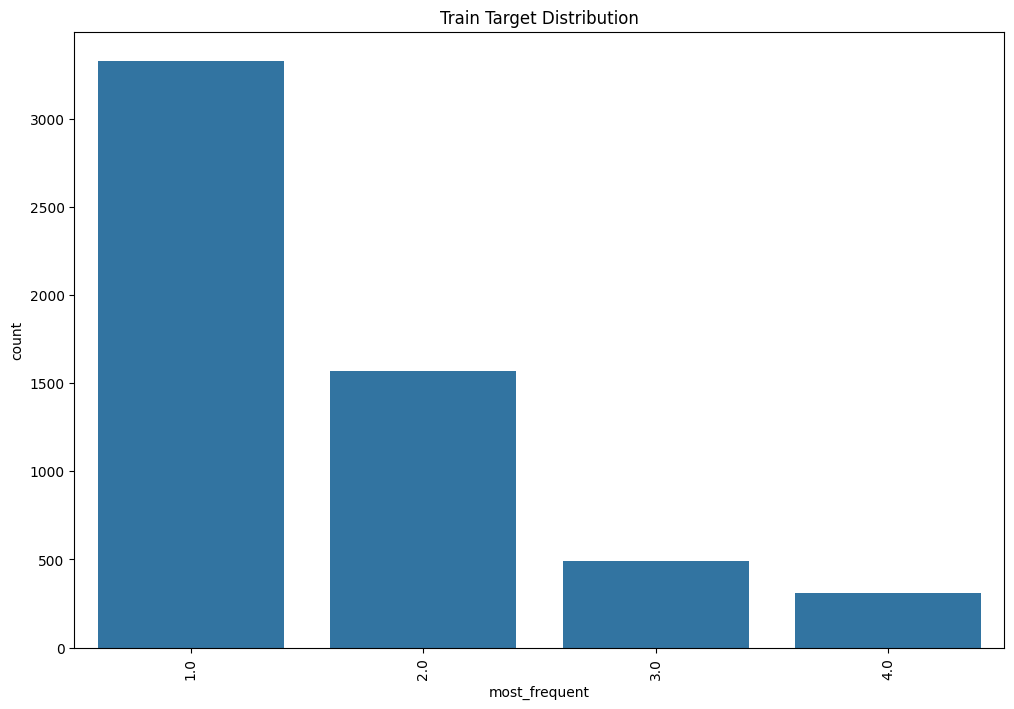

In [16]:
#train_dataset['score_avg_rounded'] = train_dataset['score_avg'].round(2)


plt.figure(figsize=(12, 8))
sns.countplot(data=train_dataset, x='most_frequent') 
plt.title('Train Target Distribution')
plt.xticks(rotation=90)
plt.show()

In [17]:
#train_dataset = train_dataset.drop('score_avg_rounded', axis=1)

распределение таргета в тесте не оч нравиться (

In [18]:
train_dataset

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  score_1  score_2  \
0     A young child is wearing blue goggles and sitt...        1        1   
1     A young child is wearing blue goggles and sitt...        1        1   
2     A young child is wearing blue goggles and sitt...        1        2   
3     A young child is wearing blue goggles and sitt...        4        4   
4     A young child is wearing blue goggles and sitt...        1        1   
...                                                 ...      ...      ...   
5817         A man in an ampitheater talking to a boy .        2        2   
5818          a old man walks down the uncrowded road .        1        1   
5819       A dog stands on the side of a grassy cliff .        2        2   
5820                       A blurry photo of two dogs .        2        3   
5821                        A man rows his boat below .        1        1   

      score_3  most_frequent  
0           1           1.00  
1           1           1.00  
2           2           2.00  
3           4           4.00  
4           1           1.00  
...       ...            ...  
5817        3           2.00  
5818        1           1.00  
5819        2           2.00  
5820        3           3.00  
5821        1           1.00  

[5696 rows x 7 columns]

In [19]:
test_dataset_final = pd.read_csv('to_upload/test_queries.csv', sep='|', index_col=0)

In [20]:
test_dataset_final

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
3    1177994172_10d143cb8d.jpg  
4    1177994172_10d143cb8d.jpg  
..                         ...  
495   989851184_9ef368e520.jpg  
496   989851184_9ef368e520.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg  

[500 rows x 3 columns]

In [21]:
stop_words = ['boy', 'boys', 'girl', 'girls', 'baby', 'babe', 'kid', 'kids', 'child', 'children',
             'toddler', 'toddlers', 'infant', 'infants', 'teenager', 'teenagers', 'youth', 'youths',
              'schoolboy', 'schoolboys', 'schoolgirl', 'schoolgirls',  'pupil', 'pupils',
              'minor', 'minors' , 'juvenile' , 'adolescent' ]

In [22]:
regex_pattern = '|'.join([re.escape(word) for word in stop_words])

mask = ~train_dataset['query_text'].str.contains(regex_pattern, case=False, na=False)

train_dataset_cln = train_dataset[mask]


In [23]:
train_dataset_cln

image                     query_id  \
22    1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23    3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24     463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25     488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26     534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
...                         ...                          ...   
5816   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  score_1  score_2  \
22      A man sleeps under a blanket on a city street .        1        1   
23      A man sleeps under a blanket on a city street .        1        2   
24      A man sleeps under a blanket on a city street .        2        2   
25      A man sleeps under a blanket on a city street .        1        2   
26      A man sleeps under a blanket on a city street .        1        1   
...                                                 ...      ...      ...   
5816  A small animal leaps behind a larger animal , ...        1        1   
5818          a old man walks down the uncrowded road .        1        1   
5819       A dog stands on the side of a grassy cliff .        2        2   
5820                       A blurry photo of two dogs .        2        3   
5821                        A man rows his boat below .        1        1   

      score_3  most_frequent  
22          2           1.00  
23          2           2.00  
24          2           2.00  
25          2           2.00  
26          2           1.00  
...       ...            ...  
5816        1           1.00  
5818        1           1.00  
5819        2           2.00  
5820        3           3.00  
5821        1           1.00  

[4148 rows x 7 columns]

In [24]:
train_dataset_cln['query_text'] = train_dataset_cln['query_text'].str.lower()
test_dataset_final['query_text'] = test_dataset_final['query_text'].str.lower()

C:\Users\MT\AppData\Local\Temp\ipykernel_21596\3028476985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_cln['query_text'] = train_dataset_cln['query_text'].str.lower()


In [25]:
train_dataset_cln

image                     query_id  \
22    1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23    3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24     463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25     488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26     534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
...                         ...                          ...   
5816   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  score_1  score_2  \
22      a man sleeps under a blanket on a city street .        1        1   
23      a man sleeps under a blanket on a city street .        1        2   
24      a man sleeps under a blanket on a city street .        2        2   
25      a man sleeps under a blanket on a city street .        1        2   
26      a man sleeps under a blanket on a city street .        1        1   
...                                                 ...      ...      ...   
5816  a small animal leaps behind a larger animal , ...        1        1   
5818          a old man walks down the uncrowded road .        1        1   
5819       a dog stands on the side of a grassy cliff .        2        2   
5820                       a blurry photo of two dogs .        2        3   
5821                        a man rows his boat below .        1        1   

      score_3  most_frequent  
22          2           1.00  
23          2           2.00  
24          2           2.00  
25          2           2.00  
26          2           1.00  
...       ...            ...  
5816        1           1.00  
5818        1           1.00  
5819        2           2.00  
5820        3           3.00  
5821        1           1.00  

[4148 rows x 7 columns]

In [26]:
def clean_text(text):
   
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I|re.A)
    
   
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [27]:
train_dataset_cln['query_text'] = train_dataset_cln['query_text'].apply(clean_text)
test_dataset_final['query_text'] = test_dataset_final['query_text'].apply(clean_text)

C:\Users\MT\AppData\Local\Temp\ipykernel_21596\1336968656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_cln['query_text'] = train_dataset_cln['query_text'].apply(clean_text)


In [28]:
wordcloud_train = WordCloud().generate(' '.join(train_dataset_cln['query_text']))
wordcloud_test = WordCloud().generate(' '.join(test_dataset_final['query_text']))

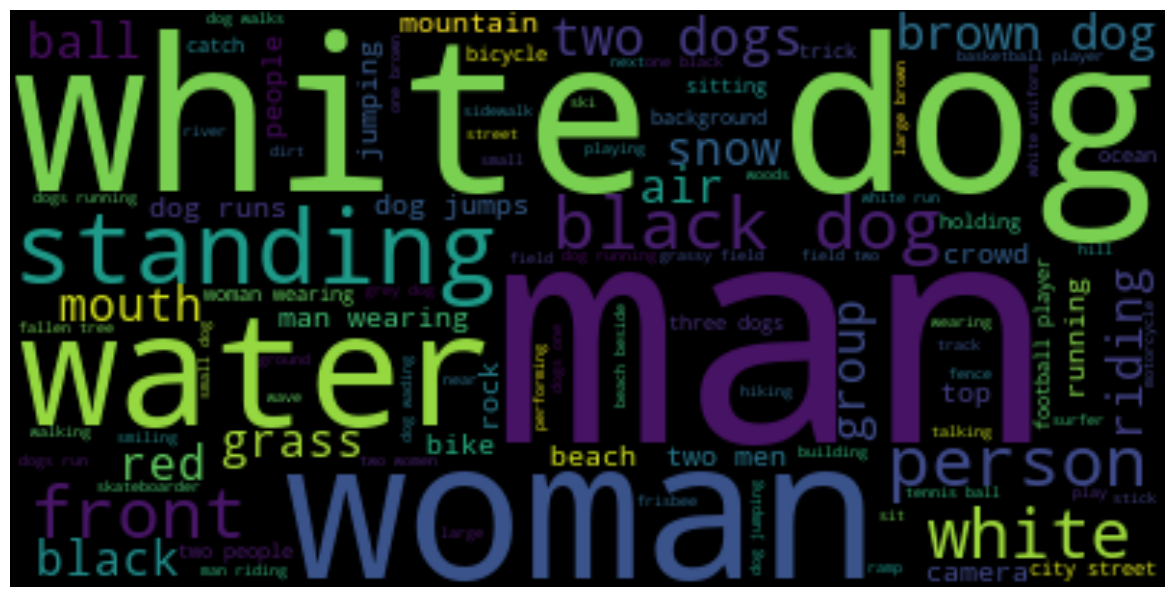

In [29]:
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis("off")
plt.show()

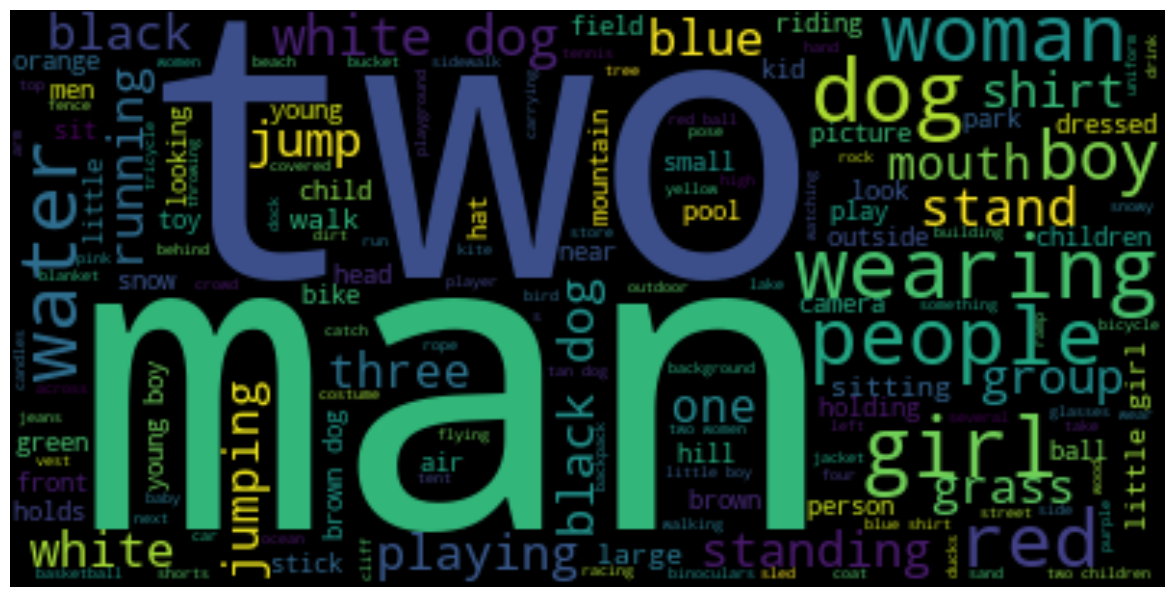

In [30]:
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_test, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
### пробовал разные модели и токенайзеры

#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#model = BertModel.from_pretrained("bert-base-uncased")

model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre") #uclanlp/visualbert-vqa-coco-pre №VisualBertModel
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")


if torch.cuda.is_available():
    model = model.to('cuda')

### cловарь для хранения векторов тексто
text_vectors = {}

### Итерация по query_text в train_dataset с использованием query_id 
for query_id, text in tqdm(train_dataset_cln[['query_id', 'query_text']].drop_duplicates().values):
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=512,  
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt'  
                   )
    
    if torch.cuda.is_available():
        encoded_dict = {k: v.to('cuda') for k, v in encoded_dict.items()}

    with torch.no_grad():
        outputs = model(**encoded_dict)
    
    ### Среднее по последовательности токенов для векторов текста
    text_vector = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    text_vectors[query_id] = text_vector



100%|██████████| 683/683 [00:07<00:00, 93.93it/s]


In [32]:
first_vector = next(iter(text_vectors.keys()))
first_vector

'3181701312_70a379ab6e.jpg#2'

In [33]:
num_pairs = len(text_vectors)
print(f"Количество пар в словаре: {num_pairs}")

Количество пар в словаре: 683


In [34]:
vector_lengths = [vector.shape[0] for vector in text_vectors.values()]
print(f"Уникальные длины векторов: {set(vector_lengths)}")

Уникальные длины векторов: {1}


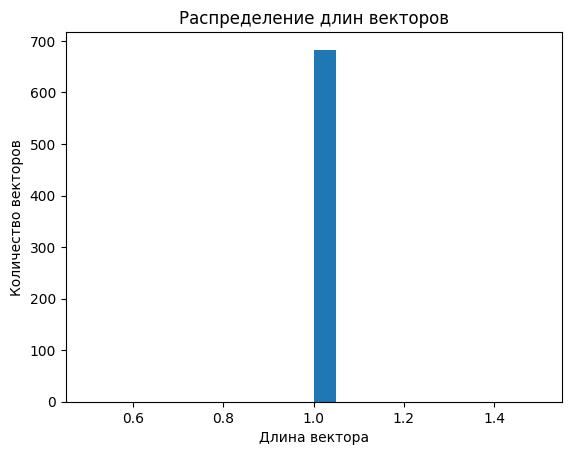

In [35]:
plt.hist(vector_lengths, bins=20)
plt.title("Распределение длин векторов")
plt.xlabel("Длина вектора")
plt.ylabel("Количество векторов")
plt.show()

In [36]:
if isinstance(next(iter(text_vectors.values())), np.ndarray):
    first_vector_shape = next(iter(text_vectors.values())).shape
    print(f"Размерность первого вектора: {first_vector_shape}")

Размерность первого вектора: (1, 768)


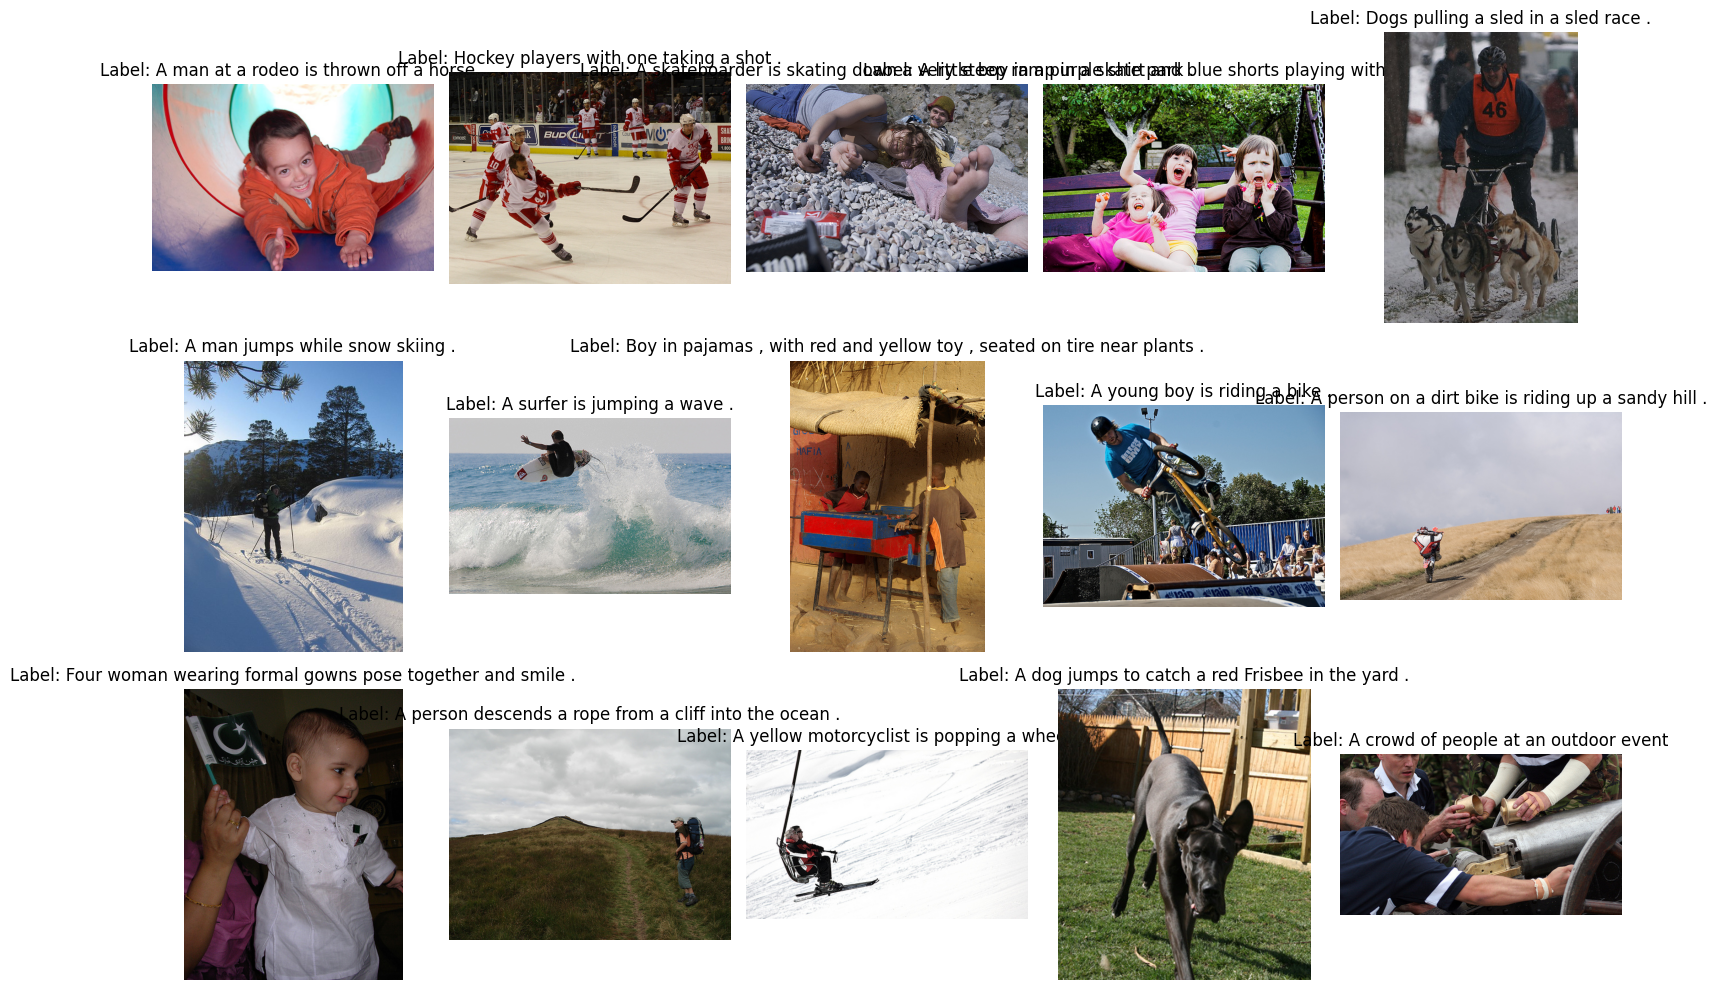

In [37]:
labels = pd.read_csv('to_upload/train_dataset.csv')  

img_dir = 'to_upload/train_images/'  

def show_images_from_directory(df, img_dir, num_images=15):
    plt.figure(figsize=(15, 10))
    sample = df.sample(n=num_images, random_state=42)  
    
    for i, (idx, row) in enumerate(sample.iterrows(), start=1):
        img_path = os.path.join(img_dir, row['image'])
        image = Image.open(img_path)
        
        ax = plt.subplot(3, 5, i)
        plt.imshow(image)
        plt.title(f'Label: {row.get("query_text", "N/A")}')  
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_from_directory(labels, img_dir)


In [38]:
weights = ResNet50_Weights.IMAGENET1K_V1
resnet = models.resnet50(weights=weights)

resnet.eval()

if torch.cuda.is_available():
    resnet = resnet.to('cuda')


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_vectors = {}

unique_images = set(train_dataset_cln['image'].to_list())

for image_name in tqdm(unique_images):
    img = Image.open(f'to_upload/train_images/{image_name}').convert('RGB') 
    
    input_tensor = preprocess(img)
    
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
    
    with torch.no_grad():
        output = resnet(input_batch)
    
    features = output.squeeze(0).cpu().numpy()
    
    image_vectors[image_name] = features




100%|██████████| 993/993 [00:07<00:00, 126.18it/s]


In [39]:
first_vector = next(iter(image_vectors.keys()))
first_vector

'189721896_1ffe76d89e.jpg'

In [40]:
num_pairs = len(image_vectors)
print(f"Количество пар в словаре: {num_pairs}")

Количество пар в словаре: 993


In [41]:
vector_lengths = [vector.shape[0] for vector in image_vectors.values()]
print(f"Уникальные длины векторов: {set(vector_lengths)}")

Уникальные длины векторов: {1000}


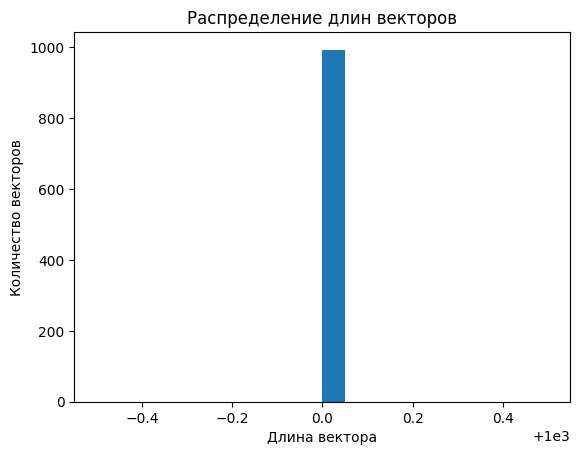

In [42]:
plt.hist(vector_lengths, bins=20)
plt.title("Распределение длин векторов")
plt.xlabel("Длина вектора")
plt.ylabel("Количество векторов")
plt.show()

In [43]:
if isinstance(next(iter(image_vectors.values())), np.ndarray):
    first_vector_shape = next(iter(image_vectors.values())).shape
    print(f"Размерность первого вектора: {first_vector_shape}")

Размерность первого вектора: (1000,)


In [44]:
train_dataset_cln.head()

image                     query_id  \
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                       query_text  score_1  score_2  score_3  \
22  a man sleeps under a blanket on a city street        1        1        2   
23  a man sleeps under a blanket on a city street        1        2        2   
24  a man sleeps under a blanket on a city street        2        2        2   
25  a man sleeps under a blanket on a city street        1        2        2   
26  a man sleeps under a blanket on a city street        1        1        2   

    most_frequent  
22           1.00  
23           2.00  
24           2.00  
25           2.00  
26           1.00

In [45]:
train_dataset_cln.query("image == '3457045393_2bbbb4e941.jpg'")

image                     query_id  \
1431  3457045393_2bbbb4e941.jpg  2788945468_74a9618cfa.jpg#2   
5060  3457045393_2bbbb4e941.jpg  2431470169_0eeba7d602.jpg#2   

                                             query_text  score_1  score_2  \
1431  a middle aged man is standing next to a white ...        1        1   
5060  man reading a newspaper at an outdoors restaurant        1        1   

      score_3  most_frequent  
1431        1           1.00  
5060        2           1.00

In [46]:
def get_combined_vector(row):
    query_id = row['query_id']
    image_name = row['image']
    text_vector = text_vectors.get(query_id)
    image_vector = image_vectors.get(image_name)
    
    if text_vector is not None and image_vector is not None:
        
        combined_vector = np.concatenate([text_vector.reshape(-1), image_vector])
        return combined_vector
    else:
        return None

train_dataset_cln['combined_features'] = train_dataset.apply(get_combined_vector, axis=1)


C:\Users\MT\AppData\Local\Temp\ipykernel_21596\3327070983.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_cln['combined_features'] = train_dataset.apply(get_combined_vector, axis=1)


In [47]:
train_dataset_cln

image                     query_id  \
22    1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23    3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24     463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25     488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26     534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
...                         ...                          ...   
5816   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  score_1  score_2  \
22        a man sleeps under a blanket on a city street        1        1   
23        a man sleeps under a blanket on a city street        1        2   
24        a man sleeps under a blanket on a city street        2        2   
25        a man sleeps under a blanket on a city street        1        2   
26        a man sleeps under a blanket on a city street        1        1   
...                                                 ...      ...      ...   
5816  a small animal leaps behind a larger animal th...        1        1   
5818            a old man walks down the uncrowded road        1        1   
5819         a dog stands on the side of a grassy cliff        2        2   
5820                         a blurry photo of two dogs        2        3   
5821                          a man rows his boat below        1        1   

      score_3  most_frequent  \
22          2           1.00   
23          2           2.00   
24          2           2.00   
25          2           2.00   
26          2           1.00   
...       ...            ...   
5816        1           1.00   
5818        1           1.00   
5819        2           2.00   
5820        3           3.00   
5821        1           1.00   

                                      combined_features  
22    [0.22189564, 0.027537283, 0.4410118, -0.207299...  
23    [0.22189564, 0.027537283, 0.4410118, -0.207299...  
24    [0.22189564, 0.027537283, 0.4410118, -0.207299...  
25    [0.22189564, 0.027537283, 0.4410118, -0.207299...  
26    [0.22189564, 0.027537283, 0.4410118, -0.207299...  
...                                                 ...  
5816  [-0.2804333, -0.03771391, 0.06765884, -0.10437...  
5818  [0.0904219, -0.029291535, 0.16626716, -0.21843...  
5819  [-0.16107367, -0.08830339, 0.13893811, -0.1541...  
5820  [0.14116852, -0.12656415, 0.18009429, -0.28937...  
5821  [0.20027074, 0.0028182957, 0.45797884, -0.1808...  

[4148 rows x 8 columns]

In [48]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)


train_indices, test_indices = next(gss.split(X=None, y=train_dataset_cln['most_frequent'], groups=train_dataset_cln['image']))

train_df = train_dataset_cln.iloc[train_indices]
test_df = train_dataset_cln.iloc[test_indices]

In [49]:
train_df.shape, test_df.shape

((3321, 8), (827, 8))

In [50]:
scaler = MinMaxScaler(feature_range=(0 , 1))

train_df['target'] = scaler.fit_transform(train_df['most_frequent'].to_numpy().reshape(-1, 1))
test_df['target'] = scaler.transform(test_df['most_frequent'].to_numpy().reshape(-1, 1))


C:\Users\MT\AppData\Local\Temp\ipykernel_21596\2946619283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['target'] = scaler.fit_transform(train_df['most_frequent'].to_numpy().reshape(-1, 1))
C:\Users\MT\AppData\Local\Temp\ipykernel_21596\2946619283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'] = scaler.transform(test_df['most_frequent'].to_numpy().reshape(-1, 1))


In [51]:
train_df.target.describe(), test_df.target.describe()

(count   3,321.00
 mean        0.22
 std         0.30
 min         0.00
 25%         0.00
 50%         0.00
 75%         0.33
 max         1.00
 Name: target, dtype: float64,
 count   827.00
 mean      0.22
 std       0.29
 min       0.00
 25%       0.00
 50%       0.00
 75%       0.33
 max       1.00
 Name: target, dtype: float64)

In [52]:
test_df

image                     query_id  \
25     488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
28    3208074567_ac44aeb3f3.jpg  3207358897_bfa61fa3c6.jpg#2   
43    3630332976_fdba22c50b.jpg  3360930596_1e75164ce6.jpg#2   
69    3562050678_4196a7fff3.jpg   434792818_56375e203f.jpg#2   
97    2393264648_a280744f97.jpg  2398605966_1d0c9e6a20.jpg#2   
...                         ...                          ...   
5791   424779662_568f9606d0.jpg  2876993733_cb26107d18.jpg#2   
5800   968081289_cdba83ce2e.jpg  2162564553_96de62c7e6.jpg#2   
5801   415793623_6c1225ae27.jpg  2554081584_233bdf289a.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  score_1  score_2  \
25        a man sleeps under a blanket on a city street        1        2   
28    a woman plays with long red ribbons in an empt...        1        1   
43    a soccer ball is above the head of a man weari...        1        1   
69    a man and woman look back at the camera while ...        1        1   
97    two longhaired puppy dogs have a romp in the snow        1        1   
...                                                 ...      ...      ...   
5791  two lonely fans in green ponchos sit in a stadium        1        1   
5800  a shirtless man in a pink hat stands on a rock...        1        1   
5801  a man wearing a yellow shirt and white hardhat...        1        2   
5820                         a blurry photo of two dogs        2        3   
5821                          a man rows his boat below        1        1   

      score_3  most_frequent  \
25          2           2.00   
28          1           1.00   
43          1           1.00   
69          1           1.00   
97          1           1.00   
...       ...            ...   
5791        2           1.00   
5800        2           1.00   
5801        2           2.00   
5820        3           3.00   
5821        1           1.00   

                                      combined_features  target  
25    [0.22189564, 0.027537283, 0.4410118, -0.207299...    0.33  
28    [0.3776515, -0.16024488, 0.21365386, -0.145910...    0.00  
43    [0.07465421, -0.013351623, 0.16517162, -0.1827...    0.00  
69    [0.24577528, 0.0067226756, 0.2634592, -0.24509...    0.00  
97    [0.10916859, -0.068923414, 0.28658623, -0.1272...    0.00  
...                                                 ...     ...  
5791  [0.2703059, -0.0220444, 0.122588895, -0.146396...    0.00  
5800  [0.017626593, -0.045121334, 0.21451503, -0.165...    0.00  
5801  [-0.07635015, 0.12818865, 0.036050856, -0.1865...    0.33  
5820  [0.14116852, -0.12656415, 0.18009429, -0.28937...    0.67  
5821  [0.20027074, 0.0028182957, 0.45797884, -0.1808...    0.00  

[827 rows x 9 columns]

In [53]:
X_train = train_df['combined_features']
y_train= train_df['target']
X_test = test_df['combined_features']
y_test = test_df['target']

In [54]:
X_train_list = list(X_train)  
X_train_np = np.array(X_train_list)  
print(X_train_np.shape)

y_train_np = y_train.to_numpy()  
print(y_train_np.shape)

X_train_tensor = torch.from_numpy(X_train_np).float()
y_train_tensor = torch.from_numpy(y_train_np).float()

print(X_train_tensor.shape)  
print(y_train_tensor.shape)  


X_test_np = np.array(list(X_test))
y_test_np = y_test.to_numpy()

X_test_tensor = torch.from_numpy(X_test_np).float()
y_test_tensor = torch.from_numpy(y_test_np).float()


print(X_test_tensor.shape)  
print(y_test_tensor.shape)

(3321, 1768)
(3321,)
torch.Size([3321, 1768])
torch.Size([3321])
torch.Size([827, 1768])
torch.Size([827])


In [55]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3321,), (3321,), (827,), (827,))

In [56]:
model_lr = LinearRegression()

scores = cross_val_score(model_lr, X_train_np, y_train, cv=5, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)
print("Среднее значение RMSE по фолдам:", rmse_scores.mean())


Среднее значение RMSE по фолдам: 0.8201861011887104


Код использовался для подбора параметров, раскодировать при необходимости, внимание, могли быть изменненыы переменные при следующих итерациях кода

'''
%%time
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 4000),
        'depth': trial.suggest_int('depth', 1, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-9, 10),
        'loss_function': 'RMSE',
        'random_seed': 42,
        'verbose': False,
        'task_type': 'GPU'
    }
    
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    X = np.stack(X_train_np)
    y = train_df['target'].values
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
        
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(rmse)
    
    average_rmse = np.mean(scores)
    return average_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
print(f'Best trial mean RMSE: {best_trial.value}')
for key, value in best_trial.params.items():
    print(f'{key}: {value}')
'''

In [57]:
best_params = {
    'iterations': 3689,
     'depth': 6,
     'learning_rate': 0.04766692216833889,
     'random_strength': 5.324236953685141,
     'bagging_temperature': 0.42118449618254195,
     'l2_leaf_reg': 6.814740724915491}

In [58]:
X_train_cb = np.stack(X_train_np)
y_train_cb = y_train_np #np.stack(y_train_np)

# Создание Pool объекта для CatBoost
train_pool = Pool(X_train_cb, y_train_cb)

# Параметры модели
best_params = {
    'iterations': 3689,
     'depth': 6,
     'learning_rate': 0.04766692216833889,
     'random_strength': 5.324236953685141,
     'bagging_temperature': 0.42118449618254195,
     'l2_leaf_reg': 6.814740724915491}
best_params.update({
    'random_seed': 42,
    'verbose': 800,
    'task_type': 'GPU',
    'loss_function': 'RMSE'
})

cv_params = best_params.copy()

In [59]:
cv_results = cv(
    params=cv_params,
    pool=train_pool,
    fold_count=5,
    seed=42,
    shuffle=True,
    verbose=800
)

mean_rmse = np.mean(cv_results['test-RMSE-mean'])
print(f'Mean RMSE from CV: {mean_rmse}')


Training on fold [0/5]
0:	learn: 0.3629589	test: 0.3707417	best: 0.3707417 (0)	total: 61.7ms	remaining: 3m 47s
800:	learn: 0.0931352	test: 0.2242280	best: 0.2242179 (799)	total: 37.5s	remaining: 2m 15s
1600:	learn: 0.0657804	test: 0.2237260	best: 0.2236709 (1553)	total: 1m 12s	remaining: 1m 35s
2400:	learn: 0.0559813	test: 0.2234058	best: 0.2233959 (2399)	total: 1m 47s	remaining: 57.5s
3200:	learn: 0.0500902	test: 0.2235387	best: 0.2233357 (2617)	total: 2m 21s	remaining: 21.5s
3688:	learn: 0.0476956	test: 0.2235423	best: 0.2233357 (2617)	total: 2m 41s	remaining: 0us
bestTest = 0.223335664
bestIteration = 2617
Training on fold [1/5]
0:	learn: 0.3674592	test: 0.3511690	best: 0.3511690 (0)	total: 52ms	remaining: 3m 11s
800:	learn: 0.1005074	test: 0.2208825	best: 0.2208825 (800)	total: 37s	remaining: 2m 13s
1600:	learn: 0.0750954	test: 0.2195959	best: 0.2195324 (1577)	total: 1m 11s	remaining: 1m 33s
2400:	learn: 0.0670290	test: 0.2192260	best: 0.2192036 (2329)	total: 1m 39s	remaining: 53.2

In [60]:
model_cb = CatBoostRegressor(**best_params)
model_cb.fit(train_pool)

# Предсказания на тестовом наборе данных
X_test_cb = np.stack(X_test_np) 
preds_cb = model_cb.predict(X_test_cb)

0:	learn: 0.2965531	total: 53.8ms	remaining: 3m 18s
800:	learn: 0.1068509	total: 37.5s	remaining: 2m 15s
1600:	learn: 0.0785282	total: 1m 12s	remaining: 1m 34s
2400:	learn: 0.0686528	total: 1m 44s	remaining: 56s
3200:	learn: 0.0605742	total: 2m 18s	remaining: 21.1s
3688:	learn: 0.0580414	total: 2m 38s	remaining: 0us


In [61]:
rmse_test = np.sqrt(mean_squared_error(y_test_np, preds_cb))
print(f'RMSE на тестовом наборе: {rmse_test}')

RMSE на тестовом наборе: 0.2400790106869798


Код использовался для подбора параметров, раскодировать при необходимости, внимание, могли быть изменненыы переменные при следующих итерациях кода

In [62]:
'''
def create_model():
    layers = []
    in_features = 1768  # Исходное количество признаков
    # Первый слой
    layers.append(nn.Linear(in_features, 220))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(p=0.2))
    # Второй слой
    layers.append(nn.Linear(220, 100))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(p=0.2))
    # Выходной слой для регрессии
    layers.append(nn.Linear(100, 1))
    return nn.Sequential(*layers)
    '''

'\ndef create_model():\n    layers = []\n    in_features = 1768  # Исходное количество признаков\n    # Первый слой\n    layers.append(nn.Linear(in_features, 220))\n    layers.append(nn.ReLU())\n    layers.append(nn.Dropout(p=0.2))\n    # Второй слой\n    layers.append(nn.Linear(220, 100))\n    layers.append(nn.ReLU())\n    layers.append(nn.Dropout(p=0.2))\n    # Выходной слой для регрессии\n    layers.append(nn.Linear(100, 1))\n    return nn.Sequential(*layers)\n    '

Код использовался для подбора параметров, раскодировать при необходимости, внимание, могли быть изменненыы переменные при следующих итерациях кода

In [63]:
'''
# Количество фолдов для кросс-валидации
n_splits = 5

def objective(trial):
    # Создание модели с заданными параметрами
    model = create_model().to('cuda')
    
    # Определение оптимизатора и скорости обучения
    optimizer_name = 'Adam'
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    # Функция потерь
    criterion = nn.MSELoss()
    
    # Подготовка к кросс-валидации
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X_train_tensor):
        X_train, X_val = X_train_tensor[train_index], X_train_tensor[val_index]
        y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]
        
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
        
        for epoch in range(3000):  # Меньше эпох для демонстрации
            # Обучение модели
            model.train()
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to('cuda'), batch_y.to('cuda')
                optimizer.zero_grad()
                output = model(batch_X)
                output = output.squeeze()
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                
        # Валидация
        model.eval()
        predictions, true_vals = [], []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to('cuda'), batch_y.to('cuda')
                output = model(batch_X)
                output = output.squeeze()
                predictions.append(output)
                true_vals.append(batch_y)

        preds = torch.cat(predictions, dim=0)
        true = torch.cat(true_vals, dim=0)
        mse = criterion(preds, true)
        rmse = torch.sqrt(mse)
        rmse_scores.append(rmse.item())
    
    # Возвращаем среднюю RMSE по всем фолдам
    average_rmse = np.mean(rmse_scores)
    return average_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Уменьшено для демонстрации

best_trial = study.best_trial
print(f'Best trial average RMSE: {best_trial.value}')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')
'''

"\n# Количество фолдов для кросс-валидации\nn_splits = 5\n\ndef objective(trial):\n    # Создание модели с заданными параметрами\n    model = create_model().to('cuda')\n    \n    # Определение оптимизатора и скорости обучения\n    optimizer_name = 'Adam'\n    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)\n    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)\n    \n    # Функция потерь\n    criterion = nn.MSELoss()\n    \n    # Подготовка к кросс-валидации\n    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)\n    rmse_scores = []\n\n    for train_index, val_index in kf.split(X_train_tensor):\n        X_train, X_val = X_train_tensor[train_index], X_train_tensor[val_index]\n        y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]\n        \n        train_dataset = TensorDataset(X_train, y_train)\n        val_dataset = TensorDataset(X_val, y_val)\n        \n        train_loader = DataLoader(train_dataset, batch_size=256, shuff

технические записи 

240, 100 <br>
100 epoch
Best trial average RMSE: 0.14027339369058608
    lr: 8.033770987388549e-05
<p>150 epoch
Best trial average RMSE: 0.14191206991672517
    lr: 0.00046366078617576285<P>250 epoch Best trial average RMSE: 0.1293847605586052
    lr: 0.00014995740854033921


220,100<br>
500 epoch Best trial average RMSE: 0.12694972455501558
    lr: 4.5569700883251925e-05</p
<p> 1000 Best trial average RMSE: 0.12189946174621583
    lr: 4.792513272188267e-05</p
<p> 3000 epoch  Best trial average RMSE: 0.11701378375291824
    lr: 1.0717285908042622e-05
240, 1<00</p>>>

In [64]:
def msle_loss(preds, targets):
    return F.mse_loss(torch.log1p(preds), torch.log1p(targets))


### кастомная функция штрафующая за ошибку редких значений
some_weight_factor = 50
def custom_weighted_mse_loss(preds, targets):
    
    weights = torch.abs(targets - 1) * some_weight_factor + 1  
    squared_diffs = (preds - targets) ** 2
    weighted_squared_diffs = weights * squared_diffs
    return weighted_squared_diffs.mean()




def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  


###  DataLoader для обучающих данных
train_dataset = TensorDataset(X_train_tensor.to('cuda'), y_train_tensor.to('cuda'))

in_features = 1768
n_hidden_neurons_1 = 180
n_hidden_neurons_2 = 100
n_hidden_neurons_3 = 100
dropout_rate_1 = 0.2
dropout_rate_2 = 0.2
lr = 1.0717285908042622e-05
num_epochs = 1000




### CV
kf = KFold(n_splits=3, shuffle=True, random_state=42)
results = []

for train_index, val_index in kf.split(X_train_tensor):
    X_train_fold = X_train_tensor[train_index].to('cuda')
    y_train_fold = y_train_tensor[train_index].to('cuda')
    X_val_fold = X_train_tensor[val_index].to('cuda')
    y_val_fold = y_train_tensor[val_index].to('cuda')
    
    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=256, shuffle=True, num_workers=0 ) #, num_workers= 4
    val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=256, shuffle=False, num_workers=0 ) #, num_workers= 4)
    
    fnn_net = nn.Sequential(
    nn.Linear(in_features, n_hidden_neurons_1),  
    nn.ReLU(),
    #nn.Dropout(dropout_rate_1),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    #nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    #nn.ReLU(),
    #nn.Dropout(dropout_rate_2),
    nn.Linear(n_hidden_neurons_2, 1)).to('cuda')
    #nn.Sigmoid()
    
    
    
    
    
    
    optimizer = optim.Adam(fnn_net.parameters(), lr=lr)
    #criterion = msle_loss() #nn.MSELoss().to('cuda')  # Перенос функции потерь на GPU
    
    
    for epoch in range(num_epochs):
        fnn_net.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = fnn_net(X_batch).squeeze()
            loss = custom_weighted_mse_loss(preds, y_batch)#criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 100 == 0:  # Verbose 100 эпох
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')        
        
        fnn_net.eval()
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds = fnn_net(X_batch).squeeze()
                
                val_preds.append(preds.cpu().detach().numpy())  
                val_targets.append(y_batch.cpu().detach().numpy())
        
        # Используем np.concatenate для создания непрерывного массива батчи неровные
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        
        rmse = np.sqrt(np.mean((val_preds - val_targets) ** 2))
        results.append(rmse)

print(f'Средний RMSE на кросс-валидации: {np.mean(results)}')



test_loader = DataLoader(TensorDataset(X_test_tensor.to('cuda'), y_test_tensor.to('cuda')), batch_size=256, shuffle=False, num_workers=0 )

fnn_net.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = fnn_net(X_batch).squeeze()
        test_preds.append(preds.cpu().detach().numpy())
        test_targets.append(y_batch.cpu().detach().numpy())

test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

rmse_test = np.sqrt(np.mean((test_preds - test_targets) ** 2))
print(f'RMSE на тестовом наборе: {rmse_test}')

Epoch 100/1000, Loss: 0.6985696885320876
Epoch 200/1000, Loss: 0.5065135988924239
Epoch 300/1000, Loss: 0.3903675642278459
Epoch 400/1000, Loss: 0.2980721791585286
Epoch 500/1000, Loss: 0.22391804224914974
Epoch 600/1000, Loss: 0.16600289112991756
Epoch 700/1000, Loss: 0.11798820810185538
Epoch 800/1000, Loss: 0.0829048218826453
Epoch 900/1000, Loss: 0.059204438908232584
Epoch 1000/1000, Loss: 0.04060318900479211
Epoch 100/1000, Loss: 0.7430803444650438
Epoch 200/1000, Loss: 0.5653588937388526
Epoch 300/1000, Loss: 0.44549161858028835
Epoch 400/1000, Loss: 0.34791164596875507
Epoch 500/1000, Loss: 0.2699705875582165
Epoch 600/1000, Loss: 0.20444578925768533
Epoch 700/1000, Loss: 0.1500136223104265
Epoch 800/1000, Loss: 0.11031529638502333
Epoch 900/1000, Loss: 0.07795263702670734
Epoch 1000/1000, Loss: 0.0567238185968664
Epoch 100/1000, Loss: 0.6692209508683946
Epoch 200/1000, Loss: 0.49470197823312545
Epoch 300/1000, Loss: 0.38087014357248944
Epoch 400/1000, Loss: 0.28483015298843384


In [65]:
test_df['cb_preds'] = preds_cb
test_df['preds'] = test_preds

C:\Users\MT\AppData\Local\Temp\ipykernel_21596\2035745773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cb_preds'] = preds_cb
C:\Users\MT\AppData\Local\Temp\ipykernel_21596\2035745773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['preds'] = test_preds


In [66]:
test_df

image                     query_id  \
25     488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
28    3208074567_ac44aeb3f3.jpg  3207358897_bfa61fa3c6.jpg#2   
43    3630332976_fdba22c50b.jpg  3360930596_1e75164ce6.jpg#2   
69    3562050678_4196a7fff3.jpg   434792818_56375e203f.jpg#2   
97    2393264648_a280744f97.jpg  2398605966_1d0c9e6a20.jpg#2   
...                         ...                          ...   
5791   424779662_568f9606d0.jpg  2876993733_cb26107d18.jpg#2   
5800   968081289_cdba83ce2e.jpg  2162564553_96de62c7e6.jpg#2   
5801   415793623_6c1225ae27.jpg  2554081584_233bdf289a.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  score_1  score_2  \
25        a man sleeps under a blanket on a city street        1        2   
28    a woman plays with long red ribbons in an empt...        1        1   
43    a soccer ball is above the head of a man weari...        1        1   
69    a man and woman look back at the camera while ...        1        1   
97    two longhaired puppy dogs have a romp in the snow        1        1   
...                                                 ...      ...      ...   
5791  two lonely fans in green ponchos sit in a stadium        1        1   
5800  a shirtless man in a pink hat stands on a rock...        1        1   
5801  a man wearing a yellow shirt and white hardhat...        1        2   
5820                         a blurry photo of two dogs        2        3   
5821                          a man rows his boat below        1        1   

      score_3  most_frequent  \
25          2           2.00   
28          1           1.00   
43          1           1.00   
69          1           1.00   
97          1           1.00   
...       ...            ...   
5791        2           1.00   
5800        2           1.00   
5801        2           2.00   
5820        3           3.00   
5821        1           1.00   

                                      combined_features  target  cb_preds  \
25    [0.22189564, 0.027537283, 0.4410118, -0.207299...    0.33      0.18   
28    [0.3776515, -0.16024488, 0.21365386, -0.145910...    0.00      0.15   
43    [0.07465421, -0.013351623, 0.16517162, -0.1827...    0.00      0.02   
69    [0.24577528, 0.0067226756, 0.2634592, -0.24509...    0.00      0.11   
97    [0.10916859, -0.068923414, 0.28658623, -0.1272...    0.00      0.14   
...                                                 ...     ...       ...   
5791  [0.2703059, -0.0220444, 0.122588895, -0.146396...    0.00      0.18   
5800  [0.017626593, -0.045121334, 0.21451503, -0.165...    0.00      0.19   
5801  [-0.07635015, 0.12818865, 0.036050856, -0.1865...    0.33      0.17   
5820  [0.14116852, -0.12656415, 0.18009429, -0.28937...    0.67      0.20   
5821  [0.20027074, 0.0028182957, 0.45797884, -0.1808...    0.00      0.31   

      preds  
25     0.19  
28     0.33  
43     0.17  
69    -0.07  
97    -0.08  
...     ...  
5791   0.02  
5800   0.04  
5801   0.37  
5820   0.40  
5821   0.18  

[827 rows x 11 columns]

In [67]:
test_df['preds'].max()

0.8197777

In [68]:
test_df['target'].unique()

array([0.33333333, 0.        , 1.        , 0.66666667])

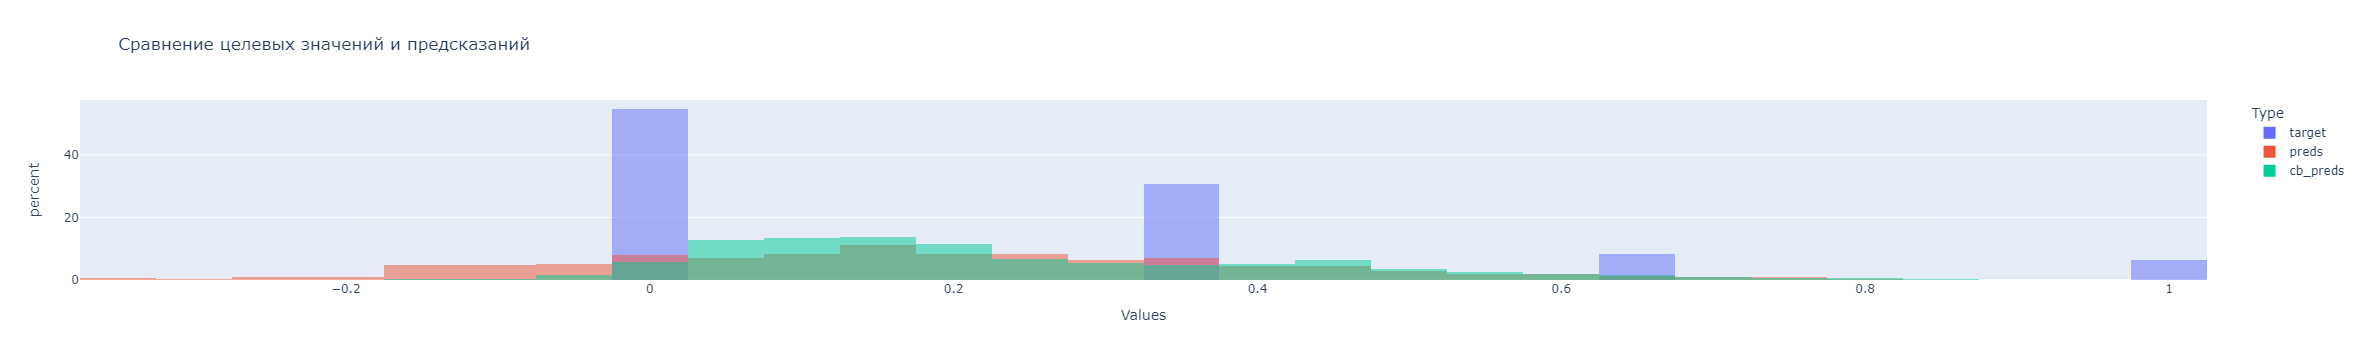

In [69]:
melted_df = test_df.melt(value_vars=['target', 'preds', 'cb_preds'], var_name='Type', value_name='Values', ignore_index=True)

# Визуализация с использованием plotly express
fig = px.histogram(melted_df, x='Values', color='Type', barmode='overlay',
                   histnorm='percent', title="Сравнение целевых значений и предсказаний")
fig.show()

In [70]:
target_values = np.array([0, 1/3, 2/3, 1])

# Функция для нахождения ближайшего значения
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Применяем функцию к каждому значению в preds
test_df['rounded_preds'] = test_df['preds'].apply(lambda x: find_nearest(target_values, x))

C:\Users\MT\AppData\Local\Temp\ipykernel_21596\1437063399.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
target_values = np.array([0, 1/3, 2/3, 1])

# Функция для нахождения ближайшего значения
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Применяем функцию к каждому значению в preds
test_df['cb_rounded_preds'] = test_df['cb_preds'].apply(lambda x: find_nearest(target_values, x))

C:\Users\MT\AppData\Local\Temp\ipykernel_21596\1006138251.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
test_df

image                     query_id  \
25     488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
28    3208074567_ac44aeb3f3.jpg  3207358897_bfa61fa3c6.jpg#2   
43    3630332976_fdba22c50b.jpg  3360930596_1e75164ce6.jpg#2   
69    3562050678_4196a7fff3.jpg   434792818_56375e203f.jpg#2   
97    2393264648_a280744f97.jpg  2398605966_1d0c9e6a20.jpg#2   
...                         ...                          ...   
5791   424779662_568f9606d0.jpg  2876993733_cb26107d18.jpg#2   
5800   968081289_cdba83ce2e.jpg  2162564553_96de62c7e6.jpg#2   
5801   415793623_6c1225ae27.jpg  2554081584_233bdf289a.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  score_1  score_2  \
25        a man sleeps under a blanket on a city street        1        2   
28    a woman plays with long red ribbons in an empt...        1        1   
43    a soccer ball is above the head of a man weari...        1        1   
69    a man and woman look back at the camera while ...        1        1   
97    two longhaired puppy dogs have a romp in the snow        1        1   
...                                                 ...      ...      ...   
5791  two lonely fans in green ponchos sit in a stadium        1        1   
5800  a shirtless man in a pink hat stands on a rock...        1        1   
5801  a man wearing a yellow shirt and white hardhat...        1        2   
5820                         a blurry photo of two dogs        2        3   
5821                          a man rows his boat below        1        1   

      score_3  most_frequent  \
25          2           2.00   
28          1           1.00   
43          1           1.00   
69          1           1.00   
97          1           1.00   
...       ...            ...   
5791        2           1.00   
5800        2           1.00   
5801        2           2.00   
5820        3           3.00   
5821        1           1.00   

                                      combined_features  target  cb_preds  \
25    [0.22189564, 0.027537283, 0.4410118, -0.207299...    0.33      0.18   
28    [0.3776515, -0.16024488, 0.21365386, -0.145910...    0.00      0.15   
43    [0.07465421, -0.013351623, 0.16517162, -0.1827...    0.00      0.02   
69    [0.24577528, 0.0067226756, 0.2634592, -0.24509...    0.00      0.11   
97    [0.10916859, -0.068923414, 0.28658623, -0.1272...    0.00      0.14   
...                                                 ...     ...       ...   
5791  [0.2703059, -0.0220444, 0.122588895, -0.146396...    0.00      0.18   
5800  [0.017626593, -0.045121334, 0.21451503, -0.165...    0.00      0.19   
5801  [-0.07635015, 0.12818865, 0.036050856, -0.1865...    0.33      0.17   
5820  [0.14116852, -0.12656415, 0.18009429, -0.28937...    0.67      0.20   
5821  [0.20027074, 0.0028182957, 0.45797884, -0.1808...    0.00      0.31   

      preds  rounded_preds  cb_rounded_preds  
25     0.19           0.33              0.33  
28     0.33           0.33              0.00  
43     0.17           0.33              0.00  
69    -0.07           0.00              0.00  
97    -0.08           0.00              0.00  
...     ...            ...               ...  
5791   0.02           0.00              0.33  
5800   0.04           0.00              0.33  
5801   0.37           0.33              0.00  
5820   0.40           0.33              0.33  
5821   0.18           0.33              0.33  

[827 rows x 13 columns]

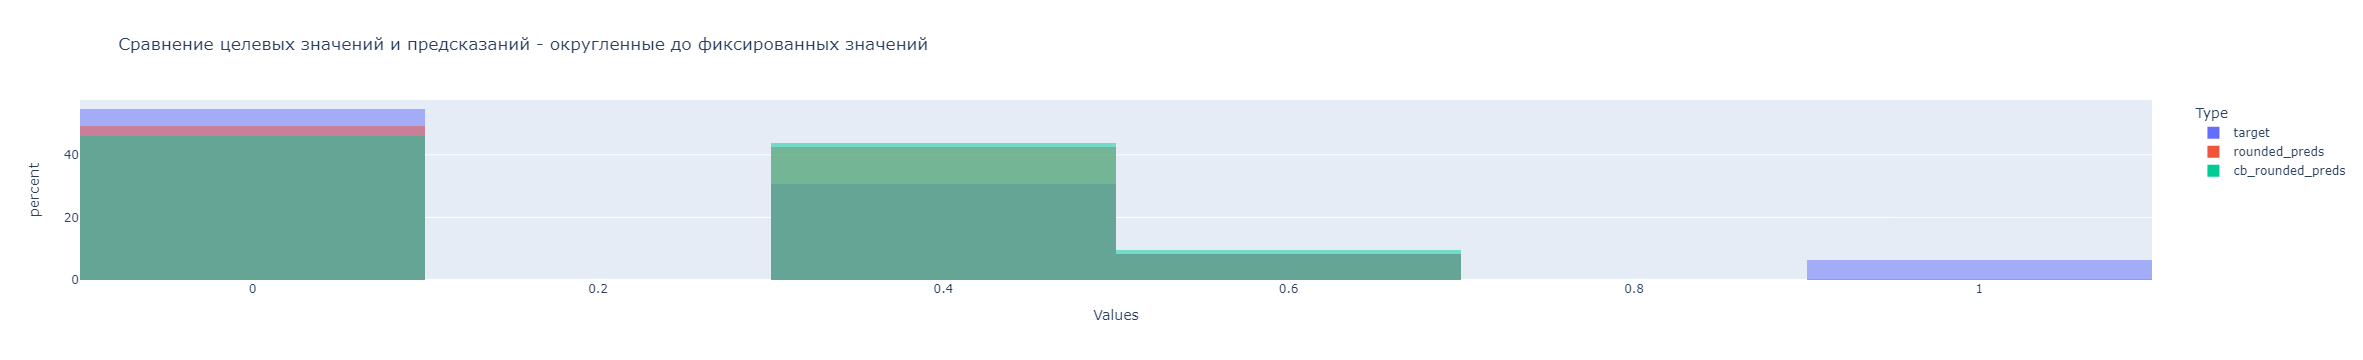

In [73]:
melted_df = test_df.melt(value_vars=['target', 'rounded_preds', 'cb_rounded_preds'], var_name='Type', value_name='Values', ignore_index=True)

fig = px.histogram(melted_df, x='Values', color='Type', barmode='overlay',
                   histnorm='percent', title="Сравнение целевых значений и предсказаний - округленные до фиксированных значений")
fig.show()

In [74]:
test_dataset_final

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    two blonde boys one in a camouflage shirt and ...   
1      two boys are squirting water guns at each other   
2              two boys spraying each other with water   
3    two children wearing jeans squirt water at eac...   
4     two young boys are squirting water at each other   
..                                                 ...   
495            a black dog has a dumbbell in his mouth   
496  a black dog has a dumbbell in his mouth lookin...   
497  a black dog holding a weight in its mouth stan...   
498  a black dog holds a small white dumbbell in it...   
499  the black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
3    1177994172_10d143cb8d.jpg  
4    1177994172_10d143cb8d.jpg  
..                         ...  
495   989851184_9ef368e520.jpg  
496   989851184_9ef368e520.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg  

[500 rows x 3 columns]

In [75]:
queries = pd.read_csv('to_upload/test_queries.csv',sep='|', index_col=0)

In [76]:
queries

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
3    1177994172_10d143cb8d.jpg  
4    1177994172_10d143cb8d.jpg  
..                         ...  
495   989851184_9ef368e520.jpg  
496   989851184_9ef368e520.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg  

[500 rows x 3 columns]

In [77]:
unique_query_ids = queries['query_id'].unique()
np.random.shuffle(unique_query_ids)  # Перемешиваем уникальные ID
selected_query_ids = unique_query_ids[:20].tolist()  # Берем первые 10 уникальных ID



In [78]:
selected_query_ids[3]

'269650644_059a84ece5.jpg#0'

In [79]:
queries.query('query_id == "2346402952_e47d0065b6.jpg#0"')

query_id  \
85  2346402952_e47d0065b6.jpg#0   

                                           query_text  \
85  Three people are looking into photographic equ...   

                        image  
85  2346402952_e47d0065b6.jpg

In [80]:
image_vectors_final = {}

### Уникальные имена файлов изображений
unique_images = set(test_dataset_final['image'].to_list())

for image_name in tqdm(unique_images):

    img = Image.open(f'to_upload/test_images/{image_name}').convert('RGB') 
    
    input_tensor = preprocess(img)
    
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
    
    with torch.no_grad():
        output = resnet(input_batch)
    
    features = output.squeeze(0).cpu().numpy()
    
    image_vectors_final[image_name] = features



100%|██████████| 100/100 [00:00<00:00, 106.40it/s]


In [92]:
selected_query_ids[5]

'3553476195_fb3747d7c1.jpg#4'

<div class="alert alert-success">
<font size="5"><b>Комментарий cтудента</b></font>

заменить selected_query_ids на любое из списка selected_query, вот таким образом selected_query_ids[3] (поменять цифру 3 на любую в диапазоне 0-19) и запустить следующую ячейку


In [107]:
query_id = selected_query_ids[19]



def encode_query_text(query_id, dataset, model, tokenizer):
    ### query_text по query_id
    query_text = dataset.loc[dataset['query_id'] == query_id, 'query_text'].values[0]
    
    # Проверка на наличие стоп-слов
    if re.search(regex_pattern, query_text, re.IGNORECASE):
        print("!!! This image is unavailable in your country in compliance with local laws !!!")
        return None
    
    ### в вектор
    encoded_input = tokenizer(query_text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    
    if torch.cuda.is_available():
        encoded_input = {k: v.to('cuda') for k, v in encoded_input.items()}

    with torch.no_grad():
        model_output = model(**encoded_input)
    
    encoded_vector = model_output.last_hidden_state.mean(dim=1).squeeze().cpu()
    
    return encoded_vector



def get_combined_features_for_all_images(query_id, dataset, model, tokenizer, image_vectors_dict):
    
    results = []

    text_vector = encode_query_text(query_id, dataset, model, tokenizer)
    if text_vector is None:
        print(f"Ошибка при кодировании текста для query_id: {query_id}.")
        return pd.DataFrame()  
    
    query_text = dataset.loc[dataset['query_id'] == query_id, 'query_text'].iloc[0]

    ### Итерация по всем изображениям в словаре 
    for image_name, image_vector in image_vectors_dict.items():
        ### concatenate текстовый и изображенческий векторы
        combined_vector = np.concatenate((text_vector.numpy(), image_vector))
        
        result = {
            'query_id': query_id,
            'image': image_name,
            'query_text': query_text,
            'features': combined_vector
        }
        results.append(result)
    
    result_df = pd.DataFrame(results)
    return result_df


result_df = get_combined_features_for_all_images(query_id, test_dataset_final, model, tokenizer, image_vectors_final)

if result_df is not None and not result_df.empty and 'features' in result_df.columns:


    result_df['features'] = result_df['features'].apply(lambda x: np.array(x).ravel())

    real_test = np.vstack(result_df['features'].values)

    real_preds_cb = model_cb.predict(real_test)

    result_df['cb_preds'] = real_preds_cb


    features_tensor = torch.tensor(np.stack(result_df['features'].values)).float()

    if torch.cuda.is_available():
        features_tensor = features_tensor.to('cuda')

    fnn_net.eval()

    fnn_net_preds = []

    with torch.no_grad():
        preds = fnn_net(features_tensor).squeeze()  # Убедитесь, что размерность совпадает

        fnn_net_preds = preds.cpu().numpy()

    result_df['fnn_net_preds'] = fnn_net_preds

    image_dir = 'to_upload/test_images/'

    max_pred_index_cb = result_df['cb_preds'].idxmax()

    max_pred_row_cb = result_df.iloc[max_pred_index_cb]
    image_path_cb = f"{image_dir}{max_pred_row_cb['image']}"
    label_cb = max_pred_row_cb['query_text']
    confidence_cb = max_pred_row_cb['cb_preds']

    img_cb = Image.open(image_path_cb)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_cb)
    plt.title(f"Label: {label_cb}\nПредсказание Catboost - уверенность: {confidence_cb:.2f}")
    plt.axis('off')
    plt.show()

    max_pred_index_fnn = result_df['fnn_net_preds'].idxmax()

    max_pred_row_fnn = result_df.iloc[max_pred_index_fnn]
    image_path_fnn = f"{image_dir}{max_pred_row_fnn['image']}"
    label_fnn = max_pred_row_fnn['query_text']
    confidence_fnn = max_pred_row_fnn['fnn_net_preds']

    img_fnn = Image.open(image_path_fnn)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_fnn)
    plt.title(f"Label: {label_fnn}\nПредсказание FNN - уверенность: {confidence_fnn:.2f}")
    plt.axis('off')
    plt.show()
    result_df
else:
    print("Процесс остановлен из-за наличия стоп-слова или другой ошибки.")

!!! This image is unavailable in your country in compliance with local laws !!!
Ошибка при кодировании текста для query_id: 3653484549_f316590b0f.jpg#3.
Процесс остановлен из-за наличия стоп-слова или другой ошибки.


<div class="alert alert-success">
<font size="5"><b>Вывод по проекту</b></font> 
<p> </p>Мы не можем сказать, что модели работают хорошо, но мы видим, что у нее есть потенциал, она как минимум хорошо отличает собак от людей, и местами выдает неплохие картинки, то есть в принципе мы понимаем, что идея скоррее всего реализуема и дальнейшая при принятии решения будет заключаться во внимаетельном механизме подоготовки векторов, вообще мне видится немного страным предложенный механизм решения, я бы попробовал реализвовать задачу, через 2 разных вектора и оценку, как референс растоясния между ними, в то же время у нас было бы и ну например евклидово растояние между векторами и по сути, мы могли бы просто имея вектора только с хорошей разметкой учить вектора, ну и наоборот создав неверные пары давать референс неверных метчей, но такой задачи у нас не стояло, а прототипа худо бедно работает!